In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col, unix_timestamp
from pyspark.ml.feature import VectorAssembler, StandardScaler

spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/11/12 22:14:11 WARN Utils: Your hostname, LAPTOP-75KMQ53F resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/12 22:14:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/12 22:14:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
batch_1_path = '../dataset/batch-dataset/batch_1.csv'
batch_2_path = '../dataset/batch-dataset/batch_2.csv'

batch_1 = spark.read.csv(batch_1_path, header=True)
batch_2 = spark.read.csv(batch_2_path, header=True)

data = batch_1.union(batch_2)

In [3]:
data.show()

+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|  content_duration| published_timestamp|         subject|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+------------------+--------------------+----------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|  200|           2147|         23|          51|        All Levels|               1.5|2017-01-18T20:58:58Z|Business Finance|
|  1113822|Complete GST Cour...|https://www.udemy...|   True|   75|           2792|        923|         274|        All Levels|              39.0|2017-03-09T16:34:20Z|Business Finance|
|  1006314|Financial Modelin...|https://www.udemy...|   True|   45|        

In [4]:
data.printSchema()

root
 |-- course_id: string (nullable = true)
 |-- course_title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- is_paid: string (nullable = true)
 |-- price: string (nullable = true)
 |-- num_subscribers: string (nullable = true)
 |-- num_reviews: string (nullable = true)
 |-- num_lectures: string (nullable = true)
 |-- level: string (nullable = true)
 |-- content_duration: string (nullable = true)
 |-- published_timestamp: string (nullable = true)
 |-- subject: string (nullable = true)



In [5]:
data = data.withColumn("price", col("price").cast("float"))
data = data.withColumn("num_subscribers", col("num_subscribers").cast("float"))
data = data.withColumn("num_reviews", col("num_reviews").cast("float"))
data = data.withColumn("content_duration", col("content_duration").cast("float"))

data = data.dropna()

if "features_unscaled" in data.columns:
    data = data.drop("features_unscaled")
if "features" in data.columns:
    data = data.drop("features")

assembler = VectorAssembler(
    inputCols=["price", "num_subscribers", "num_reviews", "content_duration"],
    outputCol="features_unscaled"
)
data = assembler.transform(data)

data.show()


+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|course_id|        course_title|                 url|is_paid|price|num_subscribers|num_reviews|num_lectures|             level|content_duration| published_timestamp|         subject|   features_unscaled|
+---------+--------------------+--------------------+-------+-----+---------------+-----------+------------+------------------+----------------+--------------------+----------------+--------------------+
|  1070968|Ultimate Investme...|https://www.udemy...|   True|200.0|         2147.0|       23.0|          51|        All Levels|             1.5|2017-01-18T20:58:58Z|Business Finance|[200.0,2147.0,23....|
|  1113822|Complete GST Cour...|https://www.udemy...|   True| 75.0|         2792.0|      923.0|         274|        All Levels|            39.0|2017-03-09T16:34:20Z|Business Finance|[7

In [6]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data.select("features_unscaled", "features").show()

+--------------------+--------------------+
|   features_unscaled|            features|
+--------------------+--------------------+
|[200.0,2147.0,23....|[3.44675681874971...|
|[75.0,2792.0,923....|[1.29253380703114...|
|[45.0,2174.0,74.0...|[0.77552028421868...|
|[95.0,2451.0,11.0...|[1.63720948890611...|
|[200.0,1276.0,45....|[3.44675681874971...|
|[150.0,9221.0,138...|[2.58506761406228...|
|[65.0,1540.0,178....|[1.12019596609365...|
|[95.0,2917.0,148....|[1.63720948890611...|
|[195.0,5172.0,34....|[3.36058789828097...|
|[200.0,827.0,14.0...|[3.44675681874971...|
|[200.0,4284.0,93....|[3.44675681874971...|
|[200.0,1380.0,42....|[3.44675681874971...|
|[30.0,3607.0,21.0...|[0.51701352281245...|
|[195.0,4061.0,52....|[3.36058789828097...|
|[200.0,294.0,19.0...|[3.44675681874971...|
|[75.0,2276.0,106....|[1.29253380703114...|
|[20.0,4919.0,79.0...|[0.34467568187497...|
|[200.0,2666.0,115...|[3.44675681874971...|
|[50.0,5354.0,24.0...|[0.86168920468742...|
|[95.0,8095.0,249....|[1.6372094

In [7]:
data.select("features").rdd.map(lambda row: len(row["features"])).distinct().collect()

[4]

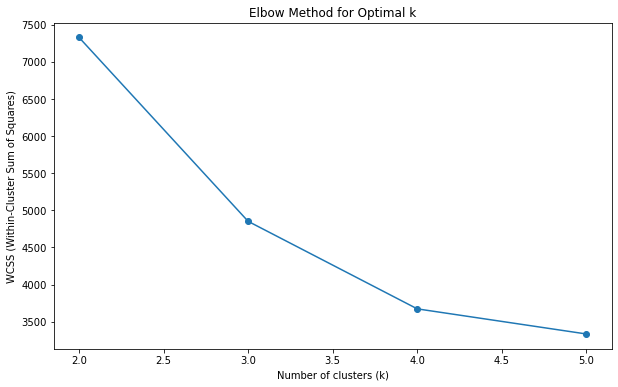

In [8]:
wcss = []

for k in range(2, 6):
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    model = kmeans.fit(data)

    wcss.append(model.summary.trainingCost)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [9]:
def find_optimal_k(data, max_k=10):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(featuresCol="features", k=k, seed=1, maxIter=100, initSteps=10)
        model = kmeans.fit(data)
        predictions = model.transform(data)
        
        evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append((k, silhouette))
        print(f"k: {k}, Silhouette Score: {silhouette}")
    
    best_k = max(silhouette_scores, key=lambda x: x[1])[0]
    print(f"\nOptimal k berdasarkan Silhouette Score adalah: {best_k}")
    
    return best_k, silhouette_scores

best_k, silhouette_scores = find_optimal_k(data, max_k=5)

kmeans = KMeans(featuresCol="features", k=best_k, seed=1, maxIter=100, initSteps=10)
model = kmeans.fit(data)

data = model.transform(data)

evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(data)
print(f"\nSilhouette Score untuk model dengan k={best_k}: {silhouette}")


data.groupBy("prediction").avg("price", "num_subscribers", "num_reviews", "content_duration").show()


k: 2, Silhouette Score: 0.9648970956361455
k: 3, Silhouette Score: 0.9044617140310004
k: 4, Silhouette Score: 0.9238852403205003
k: 5, Silhouette Score: 0.7330332974887581

Optimal k berdasarkan Silhouette Score adalah: 2

Silhouette Score untuk model dengan k=2: 0.9648970956361455
+----------+-----------------+--------------------+------------------+---------------------+
|prediction|       avg(price)|avg(num_subscribers)|  avg(num_reviews)|avg(content_duration)|
+----------+-----------------+--------------------+------------------+---------------------+
|         1|61.03725656223539|  1215.6291278577476| 40.50762066045724|   3.3466342085314746|
|         0|85.20833333333333|  37070.541666666664|2017.7083333333333|   10.341666666169962|
+----------+-----------------+--------------------+------------------+---------------------+



In [10]:
model.save("spark_kmeans_model_b")

print("Model saved to spark_kmeans_model")

Model saved to spark_kmeans_model
